# Stock Market Data

In [1]:
# Import libraries and dependencies
import os
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import numpy as np

%matplotlib inline

### Load environment variables and import Alpaca keys

In [2]:
# Load the environment variables by calling the load_dotenv function
load_dotenv()

True

In [3]:
# Set Alpaca API key and secret by calling the os.getenv function and referencing the environment variable names
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Check the values were imported correctly by evaluating the type of each
display(type(alpaca_api_key))
display(type(alpaca_secret_key))

str

str

### Setup REST object

In [4]:
# Create an Alpaca API REST object by calling the tradeapi.REST function
# Set the parameters to alpaca_api_key, alpaca_secret_key and api_version="v2" 
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

### Use the Alpaca SDK to make an API call

In [5]:
# Create a list of tickers for traditional (non-crypto) securities
tickers = ["DIA", "NDAQ", "SPY"]

In [6]:
# Set the values for start_date and end_date using the pd.Timestamp function
# Set this all to the ISO format by calling the isoformat function 
start_date = pd.Timestamp('2020-10-01', tz = "America/New_York").isoformat()
end_date = pd.Timestamp('2021-10-01', tz = "America/New_York").isoformat()

In [7]:
# Set timeframe to one day (1D)
timeframe = "1D"

# Set number of rows to 1000 to retrieve the maximum amount of rows
limit_rows = 1000

In [8]:
# Use the Alpaca get_barset function to gather the price information for each ticker
stock_prices = alpaca.get_barset(
    tickers,
    timeframe,
    start = start_date,
    end = end_date,
    limit = limit_rows
).df

# Keep only the date component of the DateTime index
stock_prices.index = stock_prices.index.date

# Review the first five rows of the resulting DataFrame 
display(stock_prices.head())
display(stock_prices.tail())

DIA                                     NDAQ                  \
              open    high     low   close   volume    open    high     low   
2020-10-01  279.33  280.35  276.57  278.12  2593183  123.92  124.57  122.87   
2020-10-02  274.17  278.51  273.60  276.78  4211692  122.66  124.67  122.26   
2020-10-05  278.79  281.59  278.75  281.40  1677309  124.19  124.99  122.70   
2020-10-06  282.54  283.52  277.24  277.67  4233910  124.84  125.79  123.09   
2020-10-07  280.28  283.67  280.23  282.89  2212655  123.38  124.80  122.18   

                               SPY                                      
             close  volume    open      high     low   close    volume  
2020-10-01  123.92  906405  337.69  338.7400  335.01  337.03  76998987  
2020-10-02  123.53  524770  331.70  337.0126  331.19  333.87  72640620  
2020-10-05  124.88  539447  336.06  339.9600  336.01  339.73  38510456  
2020-10-06  123.57  517618  339.92  342.1700  334.38  334.94  74231873  
2020-10-07  122.97  666336  338.12  341.6300  338.09  340.73  40579189

DIA                                     NDAQ                   \
              open    high     low   close   volume    open     high     low   
2021-09-27  348.29  350.50  348.12  348.59  2962818  196.50  196.640  194.52   
2021-09-28  347.33  347.82  342.41  342.94  6500883  193.83  194.330  189.38   
2021-09-29  343.90  345.67  342.88  343.83  3839304  191.64  194.410  190.92   
2021-09-30  345.08  345.44  338.11  338.28  7371559  195.10  197.334  192.92   
2021-10-01  340.00  344.78  337.68  343.19  5920343  194.05  194.750  190.66   

                                 SPY                                       
              close   volume    open      high     low   close     volume  
2021-09-27  195.805   814123  442.81  444.0500  441.90  442.68   51611925  
2021-09-28  190.960  1184653  439.69  440.0400  432.94  433.74  114959576  
2021-09-29  194.000   772300  435.19  437.0400  433.85  434.44   69828191  
2021-09-30  193.020   848464  436.02  436.7700  428.78  429.17  115315276  
2021-10-01  193.840   670129  430.98  436.0329  427.24  434.19  110774792

### Separate into individual DataFrames that contain only close prices

Dow Jones Industrial Average (DIA)

In [9]:
# Create DataFrame for DIA stock index
dia_prices = stock_prices["DIA"]

# Keep only the close prices and volume
dia_df = dia_prices.drop(columns = ["open", "high", "low"])


# Normalize all metrics by dividing volume by 20,000
dia_df["volume"] = dia_df["volume"] / 20000

# Display first 5 rows
dia_df.head()

,close,volume
2020-10-01,278.12,129.65915
2020-10-02,276.78,210.58460
2020-10-05,281.40,83.86545
2020-10-06,277.67,211.69550
2020-10-07,282.89,110.63275


Nasdaq (NDAQ)

In [10]:
# Create DataFrame for NDAQ stock index
ndaq_prices = stock_prices["NDAQ"]

# Keep only the close prices and volume
ndaq_df = ndaq_prices.drop(columns = ["open", "high", "low"])

# Normalize all metrics by dividing volume by 10,000
ndaq_df["volume"] = ndaq_df["volume"] / 10000

# Display first 5 rows
ndaq_df.head()

,close,volume
2020-10-01,123.92,90.6405
2020-10-02,123.53,52.4770
2020-10-05,124.88,53.9447
2020-10-06,123.57,51.7618
2020-10-07,122.97,66.6336


S&P 500 (SPY)

In [33]:
# Create DataFrame for SPY stock index
spy_prices = stock_prices["SPY"]

# Keep only the close prices and volume
spy_df = spy_prices.drop(columns = ["open", "high", "low"])

# Normalize all metrics by dividing volume by 350,000
spy_df["volume"] = spy_df["volume"] / 350000

# Display first 5 rows
spy_df.head()

,close,volume
2020-10-01,337.03,219.997106
2020-10-02,333.87,207.544629
2020-10-05,339.73,110.029874
2020-10-06,334.94,212.091066
2020-10-07,340.73,115.940540


### BOLLINGER BAND STRATEGY

In [34]:
# Create a function that generates a DataFrame of Bollinger band data for custom SMAs
def bollinger(data, window):
    
    bb_data = pd.DataFrame()
    
    # Add columns to display close prices and volume from called data
    bb_data["close"] = data["close"]
    bb_data["volume"] = data["volume"]
    
    # Use the Pandas 'rolling' and 'mean' functions to calculate an SMA based on a given window
    # Add the data to a column called 'sma'
    sma = data["close"].rolling(window = window).mean()
    bb_data["sma"] = sma
    
    # Use the Pandas 'rolling' and 'std' functions to calculate a rolling std based on a given window
    # Add the respective data to columns 'lower' and 'upper'  
    std = data["close"].rolling(window = window).std()
    bb_data["lower"] = sma - std * 1.9
    bb_data["upper"] = sma + std * 1.9
    
    print(f"Data is based on a {window}-day SMA.")
    
    return bb_data

In [35]:
# Generate a Bollinger band DataFrame for SPY. Play around with differetn values for 'window'.
spy_bb = bollinger(spy_df, 10)

# Display DataFrame
spy_bb

Data is based on a 10-day SMA.


,close,volume,sma,lower,upper
2020-10-01,337.03,219.997106,NaN,NaN,NaN
2020-10-02,333.87,207.544629,NaN,NaN,NaN
2020-10-05,339.73,110.029874,NaN,NaN,NaN
2020-10-06,334.94,212.091066,NaN,NaN,NaN
2020-10-07,340.73,115.940540,NaN,NaN,NaN
...,...,...,...,...,...
2021-09-27,442.68,147.462643,441.590,432.209301,450.970699
2021-09-28,433.74,328.455931,440.546,430.267263,450.824737
2021-09-29,434.44,199.509117,439.203,429.618819,448.787181
2021-09-30,429.17,329.472217,437.406,427.710036,447.101964


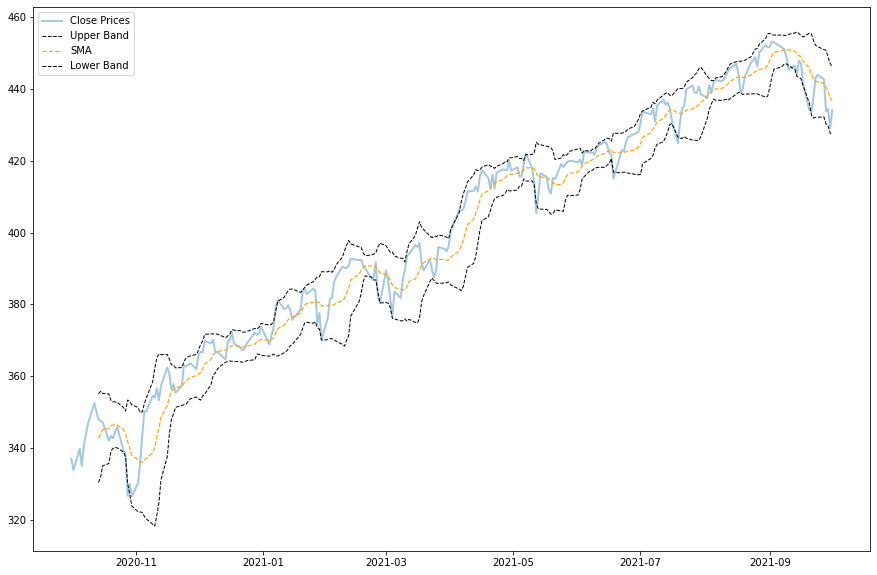

In [43]:
# Plot the DataFrame to visualize the SMA and Bollinger bands using axes objects (ax=ax)
ax = spy_bb['close'].plot(figsize = (15,10), alpha = 0.4, linewidth = 2)

# Overlay each column as a separate line on the same plot
spy_bb['upper'].plot(ax=ax, linestyle = '--', linewidth = 1, color = 'black')
spy_bb['sma'].plot(ax=ax, linestyle = '--', linewidth = 1.2, color = 'orange')
spy_bb['lower'].plot(ax=ax, linestyle = '--', linewidth = 1, color = 'black')
#spy_bb['volume'].plot(ax=ax)

# Call the legend for the plot
ax.legend(["Close Prices", "Upper Band", "SMA", "Lower Band"])


In [37]:
# Generate a Bollinger band DataFrame for NDAQ. Play around with differetn values for 'window'.
ndaq_bb = bollinger(ndaq_df, 20)

# Display DataFrame
ndaq_bb

Data is based on a 20-day SMA.


,close,volume,sma,lower,upper
2020-10-01,123.920,90.6405,NaN,NaN,NaN
2020-10-02,123.530,52.4770,NaN,NaN,NaN
2020-10-05,124.880,53.9447,NaN,NaN,NaN
2020-10-06,123.570,51.7618,NaN,NaN,NaN
2020-10-07,122.970,66.6336,NaN,NaN,NaN
...,...,...,...,...,...
2021-09-27,195.805,81.4123,195.66675,191.688825,199.644675
2021-09-28,190.960,118.4653,195.50975,191.096929,199.922571
2021-09-29,194.000,77.2300,195.42025,190.963715,199.876785
2021-09-30,193.020,84.8464,195.17175,190.759722,199.583778


<AxesSubplot:>

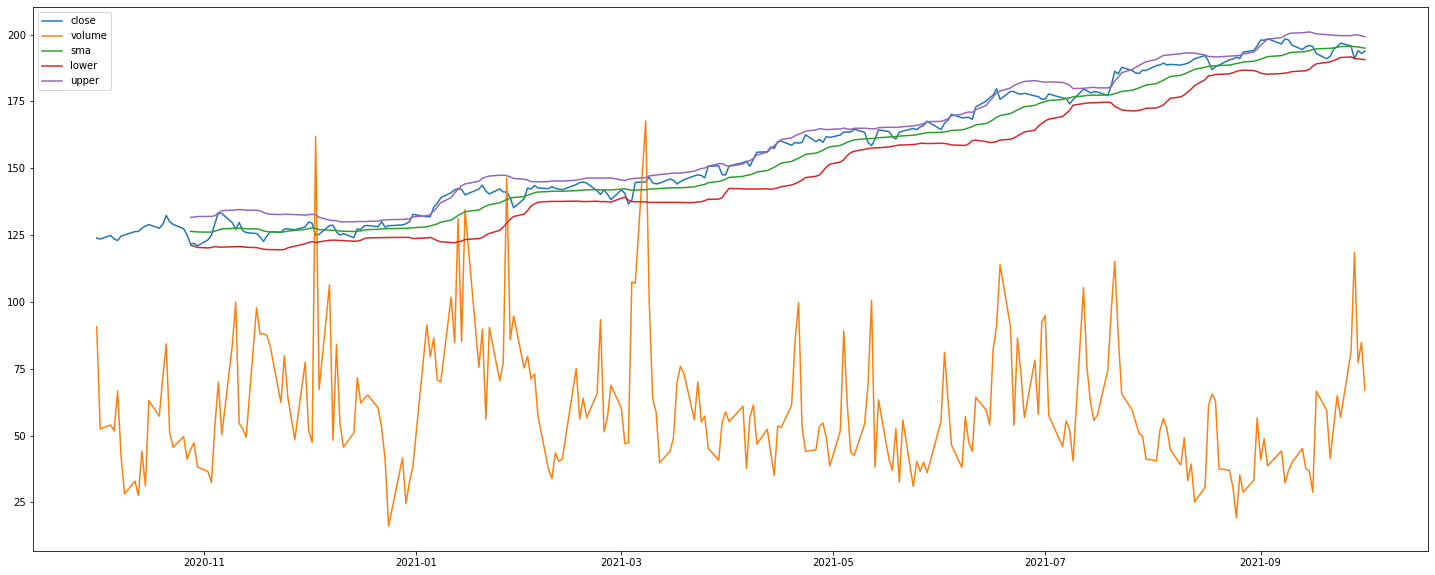

In [16]:
# Plot the DataFrame to visualize the SMA and Bollinger bands
ndaq_bb.plot(figsize=(25,10))

In [17]:
# Generate a Bollinger band DataFrame for NDAQ. Play around with differetn values for 'window'.
dia_bb = bollinger(dia_df, 20)

# Display DataFrame
dia_bb

Data is based on a 20-day SMA.


,close,volume,sma,lower,upper
2020-10-01,278.12,129.65915,NaN,NaN,NaN
2020-10-02,276.78,210.58460,NaN,NaN,NaN
2020-10-05,281.40,83.86545,NaN,NaN,NaN
2020-10-06,277.67,211.69550,NaN,NaN,NaN
2020-10-07,282.89,110.63275,NaN,NaN,NaN
...,...,...,...,...,...
2021-09-27,348.59,148.14090,348.621,339.942083,357.299917
2021-09-28,342.94,325.04415,348.062,339.429343,356.694657
2021-09-29,343.83,191.96520,347.559,339.161932,355.956068
2021-09-30,338.28,368.57795,346.794,337.975956,355.612044


<AxesSubplot:>

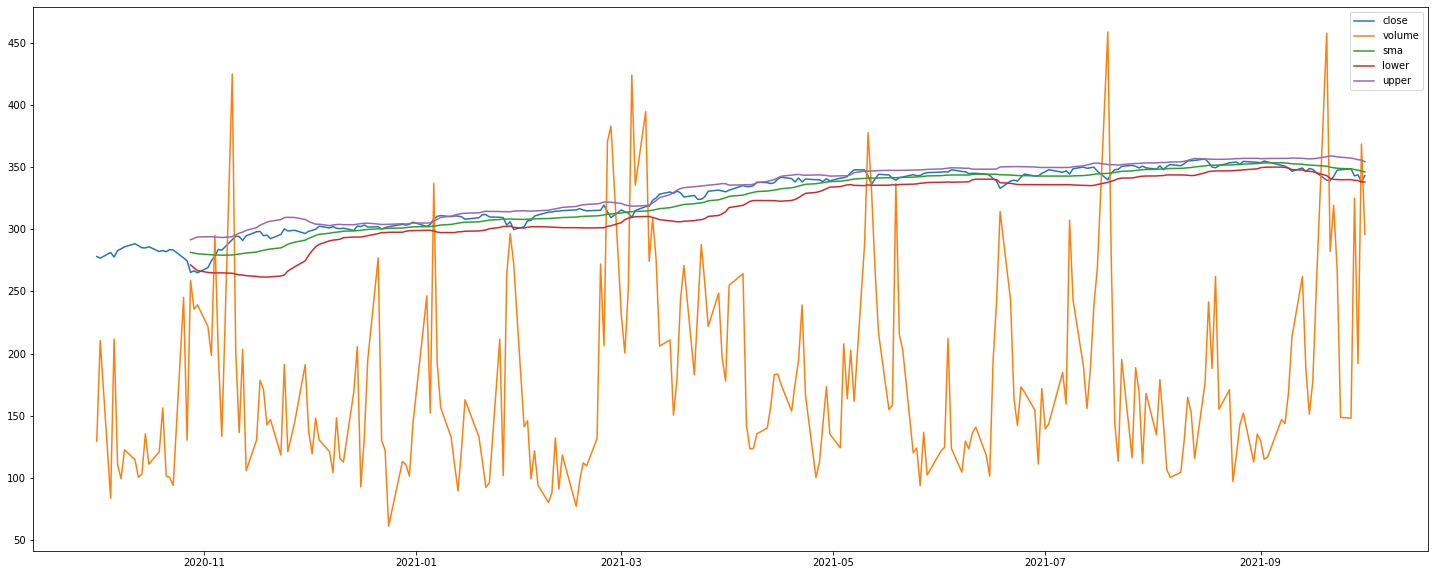

In [18]:
# Plot the DataFrame to visualize the SMA and Bollinger bands
dia_bb.plot(figsize=(25,10))